# Predicting total trips per day

In this notebook, we aim to use our weather data to help predict the number of rides that will happen on a given day. As we will see, we are mostly successful.

## Setup
We import relevant packages, perform setup work, and log in to Darwin.

In [1]:
from IPython.display import Image
from time import sleep
from sklearn.metrics import r2_score
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

DATASET_NAME = 'final_cycle_weather_by_day.csv'

ts = '{:%Y%m%d%H%M%S}'.format(datetime.now())

In [2]:
from amb_sdk.sdk import DarwinSdk
ds = DarwinSdk()
ds.set_url('https://amb-demo-api.sparkcognition.com/v1/')

status, msg = ds.auth_login_user('danny.diaz@utexas.edu', 'JcXCnQ7Wx2')
if not status:
    print(msg)
else:
    print('You are logged in: ',status)


You are logged in:  True


## Data Preparation
Reading the BCycle / weather dataset, and uploading it to Darwin. When uploading the dataset, we will see that the dataset already exists. This means that this code has been run before, and so the dataset is already uploaded.

In [3]:
df = pd.read_csv('./data/'+DATASET_NAME)
df.head(100)

,Date,Month,Year,Weekday,Avg Trip Duration,Total Rides,TempHighF,TempAvgF,DewPointHighF,DewPointAvgF,WindHighMPH,WindAvgMPH,PrecipitationSumInches,Events,PrecipBins
0,2013-12-21,12,2013,5,30.887,97,74,60,67,49,20,4,0.460,"Rain , Thunderstorm",0.1-0.5
1,2013-12-22,12,2013,6,43.385,109,56,48,43,36,16,6,0.000,Sunny,0
2,2013-12-23,12,2013,0,57.376,93,58,45,31,27,8,3,0.000,Sunny,0
3,2013-12-24,12,2013,1,33.519,81,61,46,36,28,12,4,0.000,Sunny,0
4,2013-12-25,12,2013,2,50.695,141,58,50,44,40,10,2,0.005,Sunny,0.1-0.5
5,2013-12-26,12,2013,3,54.055,91,57,48,39,36,12,3,0.000,Sunny,0
6,2013-12-27,12,2013,4,38.622,111,60,53,41,39,7,1,0.005,Sunny,0.1-0.5
7,2013-12-28,12,2013,5,43.173,191,62,51,43,39,10,2,0.005,Sunny,0.1-0.5
8,2013-12-29,12,2013,6,41.607,252,64,50,49,41,17,5,0.000,Sunny,0
9,2013-12-30,12,2013,0,18.366,82,44,40,31,26,13,5,0.000,Sunny,0


In [4]:
status, dataset = ds.upload_dataset('./data/'+DATASET_NAME)
print(status)
print(dataset)

if not status:
    print(dataset)

True
{'dataset_name': 'final_cycle_weather_by_day.csv'}


## Data cleaning
Using Darwin to clean data.

In [11]:
# We set the target column to Total Rides,
# which we are aiming to predict
target = 'Total Rides'
status, job_id = ds.clean_data(dataset_name=DATASET_NAME, 
                               target= target)
if not status:
    print(job_id)
else:
    ds.wait_for_job(job_id['job_name'])
    print('\nData has been successfully cleaned!')

{'status': 'Requested', 'starttime': '2019-04-22T20:53:53.29391', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['final_cycle_weather_by_day.csv'], 'artifact_names': ['d139d445aae44b74a6c35254e622fafa'], 'model_name': None, 'job_error': None}
{'status': 'Complete', 'starttime': '2019-04-22T20:53:53.29391', 'endtime': '2019-04-22T20:53:55.961211', 'percent_complete': 100, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['final_cycle_weather_by_day.csv'], 'artifact_names': ['d139d445aae44b74a6c35254e622fafa'], 'model_name': None, 'job_error': ''}

Data has been successfully cleaned!


## Model creation and training

We use Darwin to build a model that will learn the class labels in the target column. We train for 2 minutes, as we found that training for longer resulted in decreased accuracy.

In [12]:
model = target + "_model0" + ts
status, job_id = ds.create_model(dataset_names = DATASET_NAME, \
                                 model_name =  model, \
                                 max_train_time = '00:02')
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-04-22T20:54:09.616693', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['final_cycle_weather_by_day.csv'], 'artifact_names': None, 'model_name': 'Total Rides_model020190422204946', 'job_error': None}
{'status': 'Running', 'starttime': '2019-04-22T20:54:09.616693', 'endtime': None, 'percent_complete': 2, 'job_type': 'TrainModel', 'loss': 0.4407574534416199, 'generations': 3, 'dataset_names': ['final_cycle_weather_by_day.csv'], 'artifact_names': None, 'model_name': 'Total Rides_model020190422204946', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-22T20:54:09.616693', 'endtime': None, 'percent_complete': 2, 'job_type': 'TrainModel', 'loss': 0.4407574534416199, 'generations': 3, 'dataset_names': ['final_cycle_weather_by_day.csv'], 'artifact_names': None, 'model_name': 'Total Rides_model020190422204946', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-22T

## Model analysis
We use Darwin to analyze the model, and report which features have a larger impact on the model.

In [13]:
# Retrieve feature importance of built model
status, artifact = ds.analyze_model(model)
sleep(1)
if status:
    ds.wait_for_job(artifact['job_name'])
else:
    print(artifact)
status, feature_importance = ds.download_artifact(artifact['artifact_name'])

{'status': 'Requested', 'starttime': '2019-04-22T20:56:26.447193', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.35911521315574646, 'generations': 3, 'dataset_names': None, 'artifact_names': ['8361e0ada5c24d9f9d89c46d7fbf8a29'], 'model_name': 'Total Rides_model020190422204946', 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T20:56:26.447193', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.35911521315574646, 'generations': 3, 'dataset_names': None, 'artifact_names': ['8361e0ada5c24d9f9d89c46d7fbf8a29'], 'model_name': 'Total Rides_model020190422204946', 'job_error': None}
{'status': 'Complete', 'starttime': '2019-04-22T20:56:26.447193', 'endtime': '2019-04-22T20:56:50.830635', 'percent_complete': 100, 'job_type': 'AnalyzeModel', 'loss': 0.35911521315574646, 'generations': 3, 'dataset_names': None, 'artifact_names': ['8361e0ada5c24d9f9d89c46d7fbf8a29'], 'model_name': 'Total Rides_model020190422204946', 'job

These are the ten most important features of the model.

In [14]:
feature_importance[:10]

Avg Trip Duration    0.204534
Month = 3            0.133748
Weekday = 5          0.080535
TempHighF            0.076483
TempAvgF             0.066083
Month = 10           0.062911
WindHighMPH          0.059412
DewPointHighF        0.043241
DewPointAvgF         0.042360
Weekday = 6          0.034651
dtype: float64

We will later see that this model has a pretty accurate predictive power. <br> What is interesting to note is the features that are the most important. Namely, whether it is March and whether it is October (the months of SXSW and ACL, respectively) contribute a lot to the total number of rides. The other features are not too surprising: the high and average temperature (which may discourage riders), whether it is Saturday or Sunday (Weekday = 5, 6), the wind speed, the dewpoint (which is related to comfort), and the precipitation (all of which may discourage riders). Furthermore, note that the average trip duration column---which tells the average trip duration for a day---does not show up in these most important features. This is a good thing, as one can estimate the other features from the morning forecast, but it is harder to know the average trip duration for a day before that day occurs. This also shows that these two factors are not heavily related.

## Predictions
In creating the model, Darwin previously withheld a portion of the dataset for testing. We use our model to predict the target column label (in this case, total rides per day) on the testing set. We then download the predictions from Darwin's server.

In [15]:
status, artifact = ds.run_model(DATASET_NAME, model)
sleep(1)
ds.wait_for_job(artifact['job_name'])

{'status': 'Requested', 'starttime': '2019-04-22T20:56:59.073515', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.35911521315574646, 'generations': 3, 'dataset_names': ['final_cycle_weather_by_day.csv'], 'artifact_names': ['ade2522628cb4a02b39b1e61fdcff96a'], 'model_name': 'Total Rides_model020190422204946', 'job_error': None}
{'status': 'Complete', 'starttime': '2019-04-22T20:56:59.073515', 'endtime': '2019-04-22T20:57:09.1822', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.35911521315574646, 'generations': 3, 'dataset_names': ['final_cycle_weather_by_day.csv'], 'artifact_names': ['ade2522628cb4a02b39b1e61fdcff96a'], 'model_name': 'Total Rides_model020190422204946', 'job_error': ''}


(True, 'Job completed')

In [16]:
# We download the predictions from Darwin's server.
status, prediction = ds.download_artifact(artifact['artifact_name'])

## Model accuracy
We create a plot to compare the predicted label with the actual label. We also get the $R^2$ score. The $x$-axis is the actual total number of rides that day, and the $y$-axis the predicted label.

R^2 :  0.7656139023149349


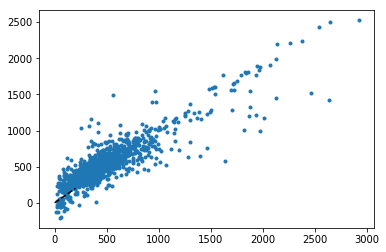

In [17]:
#Plot predictions vs actual
plt.plot(df[target], prediction[target], '.')
plt.plot([0,200],[0,200],'--k')
print('R^2 : ', r2_score(df[target], prediction[target]))

From above, we see that we have an $R^2$ score of 0.77, which is quite high. Hence, this model is quite good at predicting the total number of rides in a day. As we discuss in our report, this model could be leveraged by BCycle to predict how many bikes to have on the street for a given day, and when would be a good day to do maintenance work on bicycles or bicycle stations. <br>
The cell below shows us the type of model we used, and the parameters. Notably, Darwin used a temporal convolutional neural net.

In [18]:
status, model_type = ds.lookup_model_name(model)
print(model_type['description']['best_genome'])

[{'layer 1': {'type': 'TemporalConvolutionalNet', 'parameters': {'numfilters': 8, 'kernelsize': 9, 'depth': 6, 'numunits': 49, 'seqlength': 67, 'dropout': 0.0}}}, {'layer 2': {'type': 'TemporalConvolutionalNet', 'parameters': {'numfilters': 8, 'kernelsize': 7, 'depth': 7, 'numunits': 59, 'seqlength': 184, 'dropout': 0.0}}}, {'layer 3': {'type': 'LinearGene', 'parameters': {'activation': 'relu', 'numunits': 1}}}]


In [ ]:
ds.delete_model(model)